In [1]:
from scipy.special import expit

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

In [4]:
def load_data(wave='A', kind='train'):
    filename = '.\classification_data_HWK1\classification%s.%s'%(wave,kind)
    df = pd.read_csv(filename, sep='\t', names = ['X1', 'X2', 'y'])
    X = df.drop('y', axis=1).values
    y = df.y.values
    return X,y

In [5]:
def lda(X, y):
    """
    `lda` performs LDA estimates
    `X` : the features
    `y`: the labels
    
    """
    X_1 = X[y==1]
    X_0 = X[y==0]
    
    mu_0 = X_0.mean(axis = 0)
    mu_1 = X_1.mean(axis = 0)
    pi = y.mean()
    
    Sigma = (X_0 - mu_0).T.dot(X_0 - mu_0) + (X_1 - mu_1).T.dot(X_1 - mu_1)
    Sigma /= X.shape[0]
    Preci = np.linalg.inv(Sigma)
    a = Preci.dot(mu_1 - mu_0)
    b = np.log(pi/(1-pi)) - 0.5 * (mu_1 - mu_0).T.dot(Preci).dot(mu_1 + mu_0)
    
    return mu_0, mu_1, Sigma, Preci, pi, a, b

In [6]:
def qda(X, y):
    X_1 = X[y==1]
    X_0 = X[y==0]
    
    mu_0 = X_0.mean(axis = 0)
    mu_1 = X_1.mean(axis = 0)
    pi = y.mean()
    
    Sigma_0 = (X_0 - mu_0).T.dot(X_0 - mu_0)/ X_0.shape[0]
    Sigma_1 = (X_1 - mu_1).T.dot(X_1 - mu_1)/ X_1.shape[0] 
    
    Preci_0 = np.linalg.inv(Sigma_0)
    Preci_1 = np.linalg.inv(Sigma_1)
    
    A = -0.5 * (Preci_1 - Preci_0)
    
    a = Preci_1.dot(mu_1) - Preci_0.dot(mu_0)
    
    b = np.log(pi/(1-pi)) -0.5 * np.log(np.linalg.det(Sigma_1) / np.linalg.det(Sigma_0)) -0.5 * mu_1.T.dot(Preci_1).dot(mu_1) +0.5 * mu_0.T.dot(Preci_0).dot(mu_0) 
    
    return mu_0, mu_1, Sigma_0, Sigma_1, Preci_0, Preci_1, pi, A, a, b
    

In [7]:
def sigmoid(X):
    #return 1/(1 + np.exp(-X))
    return expit(X)

def add(X):
    N = X.shape[0]
    X_add = np.c_[X, np.ones((N,1))]
    return X_add

In [8]:
def loss(X, y, w):
    X_add = add(X)
    y_ = y[:, np.newaxis]
    epsi = 1e-04
    L =  y_ * np.log(sigmoid(X_add.dot(w)) + epsi) + (1-y_)* np.log(sigmoid(-X_add.dot(w)) + epsi)
    return L.sum()

def gradient(X, y, w, l2=0.01):
    X_add = add(X)
    y_ = y[:, np.newaxis]
    G = y_ * X_add - X_add * sigmoid(X_add.dot(w))
    g = G.sum(axis=0)
    return g[:, np.newaxis] - l2 * w

def hessian(X, y, w, l2=0.01):
    X_add = add(X)
    y_ = y[:, np.newaxis]
    
    d = sigmoid(X_add.dot(w)) * sigmoid(-X_add.dot(w))
    D = np.diag(d.flatten())
    return -X_add.T.dot(D).dot(X_add) - l2 * np.eye(3)

In [9]:
def OLS(X, y):
    X_add = add(X)
    y_ = y[:, np.newaxis]
    w = np.linalg.solve(X_add.T.dot(X_add), X_add.T.dot(y_))
    return w


def GD(X, y, w0, delta = 0.1, max_iters=20, l2=0.01):
    
    w = w0.copy()
    losses = [loss(X, y, w)]
    
    it = 0
    epsi = 1e-03
    preci = epsi + 1
    
    while (it<max_iters and preci>=epsi):
    #for i in range(max_iters):
 
        step = delta * gradient(X, y, w, l2=l2)
        w += step
        losses.append(loss(X, y, w))
        it += 1
        preci = np.linalg.norm(step)
        
    return w, losses, it

def NEWTON(X, y, w0, max_iters=20, l2=0.01):
    
    w = w0.copy()
    losses = [loss(X, y, w)]
    
    delta = 1e-03
    
    it = 0
    epsi = 1e-03
    preci = epsi + 1
    
    while (it<max_iters and preci>=epsi):
        
        H = hessian(X, y, w, l2=l2)
        G = gradient(X, y, w, l2=l2)
        try:
            step = np.linalg.solve(H, G)
        except:
            step = np.linalg.solve(H + delta * np.eye(3), G)
            print('inv')
        w -= step
        losses.append(loss(X, y, w))
        
        it +=1
        preci = np.linalg.norm(step)
        
    return w, losses, it

In [10]:
from matplotlib.colors import ListedColormap


def plot_decision_regions(X, y, classifier, ax, m, n, resolution=0.02, how='lda', title='Title'):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                         np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T, how=how)
    Z = Z.reshape(xx1.shape)
    plt.sca(ax[m-1,n-1])
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=int(cl))
        plt.legend(loc='best')
    ax[m-1,n-1].set_title(title)



In [11]:
class Job():
    
    def __init__(self, wave='A', kind='train'):
        self.X, self.y = load_data(wave, kind)
        
    def load(self, wave, kind):
        X, y = load_data(wave, kind)
        return X, y
    
    def Lda(self):
        mu_0, mu_1, Sigma, Preci, pi, a, b = lda(self.X, self.y)
        self.lda = {'mu0':mu_0, 'mu1':mu_1, 
                    'sigma':Sigma, 'preci':Preci, 
                    'pi':pi, 'a':a, 'b':b}
        
    def Qda(self):
        mu_0, mu_1, Sigma_0, Sigma_1, Preci_0, Preci_1, pi, A, a, b = qda(self.X, self.y)
        self.qda = {'mu0': mu_0, 'mu1': mu_1, 
                    'sigma0': Sigma_0, 'sigma1': Sigma_1, 'preci0': Preci_0, 'preci1': Preci_1, 
                    'pi': pi, 'A': A, 'a': a, 'b': b}
    
    def Ols(self):
        w = OLS(self.X, self.y)
        self.ols = {'w':w}
    
    def Logistic(self, w0, Newton=True, max_iters=20, l2=0.01, delta=0.01):
        if Newton:
            w, losses, it = NEWTON(self.X, self.y, w0, max_iters=max_iters, l2=l2)
        else:
            w, losses, it = GD(self.X, self.y, w0, delta = delta, max_iters=max_iters, l2=l2)
        self.logistic = {'iters':it, 'losses':losses, 'w':w, 'Newton':Newton}
    
    def plot(self, how='lda'):
        xmin = self.X[:,0].min() - 0.5
        xmax = X[:,0].max() + 0.5
        
        xt  = np.linspace(xmin, xmax, 100)
        if how=='lda':
            yt = -(1/self.lda['a'][1])*(self.lda['a'][0]*xt+self.lda['b'])
        elif how=='ols':
            yt = -(1/self.ols['w'][1])*(self.ols['w'][0]*xt+self.ols['w'][2]-0.5)
        else:
            yt = -(1/self.logistic['w'][1])*(self.logistic['w'][0]*xt+self.logistic['w'][2])
        
        plt.scatter(self.X[:,0], self.X[:,1], c=self.y)
        plt.plot(xt, yt, 'r--')
    
    
    def predict(self, X, how='lda'):
        if how=='lda':
            logit = X.dot(self.lda['a']) + self.lda['b']
        elif how=='ols':
            X_add = add(X)
            logit = X_add.dot(self.ols['w']).T
        elif how=='logistic':
            X_add = add(X)
            logit = X_add.dot(self.logistic['w']).T
        else:
            fun = lambda row: row.dot(self.qda['A'].dot(row))
            logit = X.dot(self.qda['a']) + self.qda['b'] + np.apply_along_axis(fun, 1, X)
        return (logit>0.5).astype(int)
    
    
    def score(self, X, y, how='lda'):
        prediction = self.predict(X, how=how)
        return (prediction==y).mean()
    #
    
    
##
##

## Launching Estimates.....

In [12]:
wa = np.array([[-3],[-5],[0.5]])
wb = np.array([[-2.],[2.],[1.]])
wc = np.array([[-3.2],[1.5],[1.]])

inits = [wa, wb, wc]
waves = ['A', 'B', 'C']
estimators = ['LDA','QDA','OLS','LOGIT']

jobs = []

trains = []
evals = []
datasets = []
methods = []
ws = []
bs = []

for wave, init in zip(waves, inits):
    print("\n Processing wave %s ................. \n"%wave)
    job = Job(wave=wave, kind='train')
    
    job.Lda()
    w = "(%s)"%','.join(str(c) for c in job.lda['a'].round(3))
    b = job.lda['b']
    ws.append(w)
    bs.append(b)
    
    job.Qda()
    w = "(%s)"%','.join(str(c) for c in job.qda['a'].round(3))
    b = job.qda['b']
    ws.append(w)
    bs.append(b)
    
    job.Ols()
    w = "(%s)"%','.join(str(c) for c in job.ols['w'].flatten()[:2].round(3))
    b = job.ols['w'].flatten()[2] - 0.5
    ws.append(w)
    bs.append(b)
    
    job.Logistic(init, l2=0.00)
    w = "(%s)"%','.join(str(c) for c in job.logistic['w'].flatten()[:2].round(3))
    b = job.logistic['w'].flatten()[2]
    ws.append(w)
    bs.append(b)
    
    X_test, y_test = job.load(wave=wave, kind='test')
    
    training_error_lda = job.score(job.X, job.y, how='lda')
    training_error_qda = job.score(job.X, job.y, how='qda')
    training_error_ols = job.score(job.X, job.y, how='ols')
    training_error_logistic = job.score(job.X, job.y, how='logistic')
    
    eval_error_lda = job.score(X_test, y_test, how='lda')
    eval_error_qda = job.score(X_test, y_test, how='qda')
    eval_error_ols = job.score(X_test, y_test, how='ols')
    eval_error_logistic = job.score(X_test, y_test, how='logistic')
    
    datasets.extend([wave]*4)
    trains.extend([training_error_lda, training_error_qda, training_error_ols, training_error_logistic])
    evals.extend([eval_error_lda, eval_error_qda, eval_error_ols, eval_error_logistic])
    methods.extend(estimators)
    
    jobs.append(job)
    
    
    



 Processing wave A ................. 


 Processing wave B ................. 


 Processing wave C ................. 



$ \mathbb{P}(y=1 \mid x) = 0.5 \Leftrightarrow x'Qx + w'x + b = 0  $

In [13]:
df = pd.DataFrame({'Dataset':datasets, 'Estimator':methods, 'Training Score':trains, 
                   'Test Score':evals, 'w':ws, 'b':bs})
df

,Dataset,Estimator,Test Score,Training Score,b,w
0,A,LDA,0.980000,0.993333,-0.136496,"(-6.622,-9.346)"
1,A,QDA,0.981333,0.993333,-0.626271,"(-7.365,-10.873)"
2,A,OLS,0.979333,0.986667,-0.007708,"(-0.264,-0.373)"
3,A,LOGIT,0.965333,1.000000,-65.042275,"(-390.568,-676.45)"
4,B,LDA,0.955500,0.960000,0.000929,"(-1.921,0.954)"
5,B,QDA,0.980000,0.986667,3.366502,"(-2.281,1.457)"
6,B,OLS,0.958500,0.970000,0.000050,"(-0.104,0.052)"
7,B,LOGIT,0.962000,0.976667,1.349591,"(-1.705,1.024)"
8,C,LDA,0.957333,0.940000,0.112429,"(-2.051,-0.273)"
9,C,QDA,0.964333,0.955000,0.110043,"(-2.665,0.349)"


## REPORT: MISSCLASSIFICATION  RATES

In [14]:
def get_report(dataset = 'A', save=True):
    dg = df.loc[df.Dataset==dataset,['Estimator','Test Score','Training Score']]
    dg.loc[:,['Test Score','Training Score']] = 100 * (1 - dg.loc[:,['Test Score','Training Score']])
    dg = dg.round(2)
    dg.columns = ['Estimator','Test','Train']
    if save:
        dg.to_latex('%s.tex'%dataset, index=False)
    return dg

In [15]:
get_report('A')
get_report('B')
get_report('C')

,Estimator,Test,Train
8,LDA,4.27,6.0
9,QDA,3.57,4.5
10,OLS,4.23,5.5
11,LOGIT,2.33,4.0


## Plots for Dataset A

In [16]:
methods = ['lda','logistic','ols', 'qda']
titles = ['LDA','LOGIT','OLS','QDA']
ms = [1,1,2,2]
ns = [1,2,1,2]

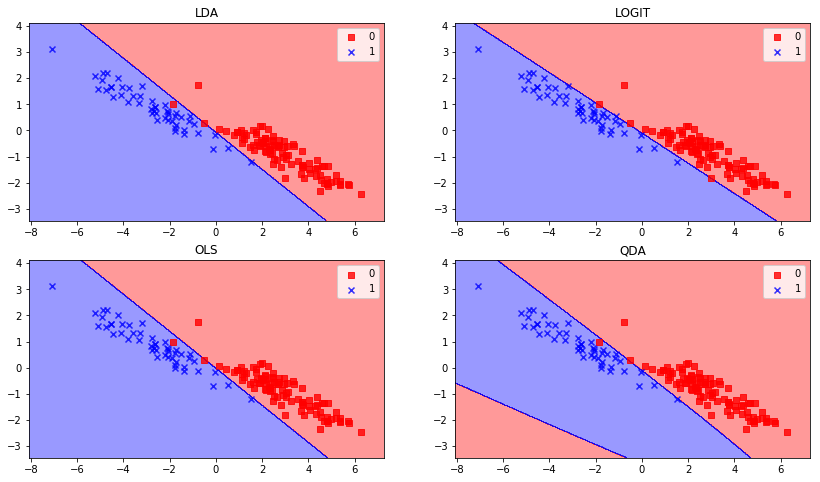

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(14,8))
job_a = jobs[0]
for method, title, m, n in zip(methods, titles, ms, ns):
    plot_decision_regions(job_a.X, job_a.y, job_a, ax, m, n, how=method, title=title)

## Plots for Dataset B

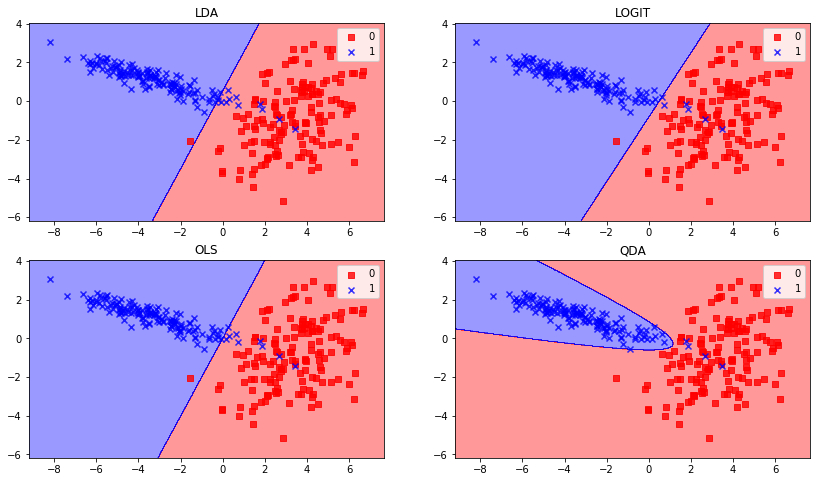

In [18]:
fig, ax = plt.subplots(2, 2, figsize=(14,8))
job_b = jobs[1]
for method, title, m, n in zip(methods, titles, ms, ns):
    plot_decision_regions(job_b.X, job_b.y, job_b, ax, m, n, how=method, title=title)

## Plots for Dataset C

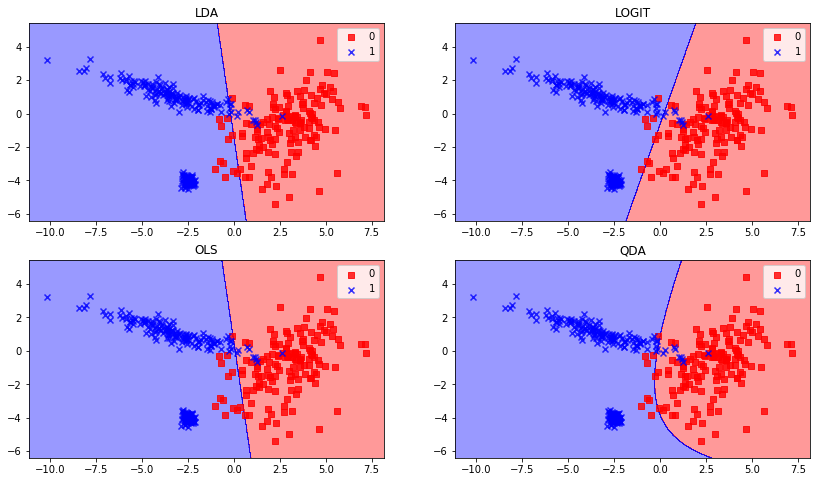

In [19]:
fig, ax = plt.subplots(2, 2, figsize=(14,8))
job_c = jobs[2]
for method, title, m, n in zip(methods, titles, ms, ns):
    plot_decision_regions(job_c.X, job_c.y, job_c, ax, m, n, how=method, title=title)